**README: This notebook contains model training for the BERT version.**

# Import Data and subset Data

## 1. Import

In [1]:
import numpy as np
import pandas as pd
import sklearn
import datetime

In [545]:
news = pd.read_csv("../data_intermed/news_bert.csv")
news = news[news['text']!=" "] # remove empty entries

In [546]:
distilBert_title_raw = np.load('../data_intermed/distilBert_title.npy')
distilBert_text_raw = np.load('../data_intermed/distilBert_text.npy')

In [547]:
def createLabels(data, col_name):
    labels = data[col_name].values
    y = np.zeros(labels.shape)
    y[labels == 'fake'] = 1
    return y

In [614]:
distilBert_title = distilBert_title_raw[news.index]
distilBert_text = distilBert_text_raw[news.index]
y = createLabels(news, 'label')

print(distilBert_text.shape)

(44271, 768)


## 2. Subset Data to only politics

In [9]:
news.subject.unique()

array(['politicsNews', 'worldnews', 'News', 'politics', 'Government News',
       'left-news', 'US_News', 'Middle-east'], dtype=object)

In [1018]:
news_p = news[news['subject'].isin(['politicsNews','politics','Government News'])]

In [1019]:
news_p.size
news_p.groupby('label').count().title

label
fake     7934
true    11271
Name: title, dtype: int64

In [1020]:
distilBert_title_p = distilBert_title[news_p.index]
distilBert_text_p = distilBert_text[news_p.index]
y_p = createLabels(news_p, 'label')

print(distilBert_text_p.shape)

(19205, 768)


In [1076]:
np.min(distilBert_text)

-8.900059700012207

## 3. Combine title and text

In [1021]:
distilBert_title_text = np.concatenate((distilBert_title, distilBert_text),1)
distilBert_title_text_p = np.concatenate((distilBert_title_p, distilBert_text_p),1)

In [1023]:
distilBert_title_text.shape, distilBert_title_text_p.shape

((44271, 1536), (19205, 1536))

# Models

We chose Naive Bayes, Logistic Regression, Linear SVM, and Neura Networks for the BERT version.

In [1024]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import json

In [1025]:
def modelEval(X_train, y_train, X_test, y_test, model, result_output_name, path = "../model_results/", printResults = True):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_perc, random_state=42)
    clf = model.fit(X_train, y_train)
    
    # predict
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    assert(y_pred_train.shape == y_train.shape)
    assert(y_pred_test.shape == y_test.shape)
    
    # save results in dictionary
    model_dict = {}
    model_dict['train accuracy'] = clf.score(X_train, y_train)
    model_dict['test accuracy'] = clf.score(X_test, y_test)
    model_dict['train f-score'] = f1_score(y_train, y_pred_train)
    model_dict['test f-score'] = f1_score(y_test, y_pred_test)
    
    # output the dictionary
    with open(path + result_output_name + ".json", "w") as outfile:  
        json.dump(model_dict, outfile) 
    
    # print
    if printResults == True:
        print('train accuracy:', model_dict['train accuracy'])
        print('test accuracy:', model_dict['test accuracy'])
        print('train f-score:', model_dict['train f-score'])
        print('test f-score:', model_dict['test f-score'])
    
    return clf, model_dict

In [1033]:
# Creates test train for all combinations of features (6 sets) for easier use later
for i in ['title','text','title_text']:
    exec("X_train_"+i+",X_test_"+i+",y_train_"+i+",y_test_"+i+
         "= train_test_split(distilBert_" +i + ",y, test_size=0.33, random_state=42)")
    exec("X_train_"+i+"_p ,X_test_"+i+"_p ,y_train_"+i+"_p ,y_test_"+i+
         "_p = train_test_split(distilBert_" +i + "_p ,y_p, test_size=0.33, random_state=42)")

## I. Naive Bayes

In [956]:
from sklearn.naive_bayes import GaussianNB

In [957]:
gnb = GaussianNB()

In [958]:
clf_nb_title = modelEval(X_train_title, y_train_title, X_test_title, y_test_title,
                         gnb, "results_nb_title")

train accuracy: 0.8516570580897475
test accuracy: 0.8499657768651608
train f-score: 0.8537914534458695
test f-score: 0.8528859060402684


In [959]:
clf_nb_text = modelEval(X_train_text, y_train_text, X_test_text, y_test_text, 
                        gnb, "results_nb_text")

train accuracy: 0.9221199554971174
test accuracy: 0.9243668720054757
train f-score: 0.924809582709459
test f-score: 0.9270193514298922


In [960]:
clf_nb_title_text = modelEval(X_train_title_text, y_train_title_text, X_test_title_text, y_test_title_text,
                              gnb, "results_nb_title_text")

train accuracy: 0.9204005259431577
test accuracy: 0.920123203285421
train f-score: 0.9226434258379477
test f-score: 0.9223191106969314


In [1034]:
clf_nb_title_p = modelEval(X_train_title_p, y_train_title_p, X_test_title_p, y_test_title_p,
                           gnb, "results_nb_title_p")

train accuracy: 0.872386725732494
test accuracy: 0.8725149889555065
train f-score: 0.8463985032740879
test f-score: 0.8482344102178814


In [1035]:
clf_nb_text_p = modelEval(X_train_text_p, y_train_text_p, X_test_text_p, y_test_text_p,
                          gnb, "results_nb_text_p")

train accuracy: 0.9232144244967747
test accuracy: 0.9222152098453771
train f-score: 0.9056171188383646
test f-score: 0.9050279329608939


In [1036]:
clf_nb_title_text_p = modelEval(X_train_title_text_p, y_train_title_text_p, X_test_title_text_p, y_test_title_text_p, 
                                gnb, "results_nb_title_text_p")

train accuracy: 0.9323851713686174
test accuracy: 0.9349952666456295
train f-score: 0.9178004535147393
test f-score: 0.9213740458015267


## II. Logistic Regression

In [621]:
from sklearn.linear_model import LogisticRegression

In [1079]:
# cross validation
def crossValidationLR(X, y, hyperparameters):
    scores = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    for h in hyperparameters:
        model = LogisticRegression(random_state=0, max_iter=2000, C=h,) #penalty='elasticnet', solver="saga", l1_ratio = 0.3)
        scores.append(cross_val_score(estimator=model, X=X_train, y=y_train, cv=10).mean())
        
    return scores

In [1080]:
scoresLR_title = crossValidationLR(X_train_title, y_train_title, range(1,6))
scoresLR_text = crossValidationLR(X_train_text, y_train_text, range(2,10))
scoresLR_title_text = crossValidationLR(X_train_title_text, y_train_title_text, range(1,10))

In [ ]:
scoresLR_text_p = crossValidationLR(X_train_text_p, y_train_text_p, range(2,10))
scoresLR_title_p = crossValidationLR(X_train_title_p, y_train_title_p, range(1,6))
scoresLR_title_text_p = crossValidationLR(X_train_title_text_p, y_train_title_text_p, range(1,10))

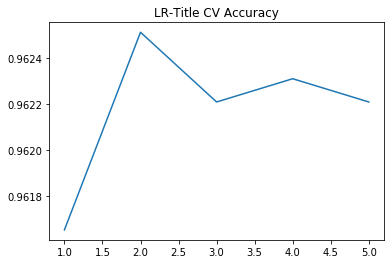

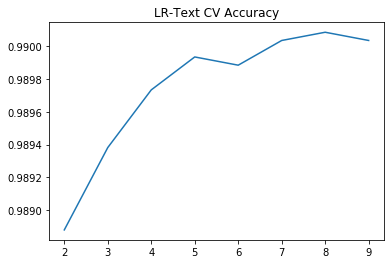

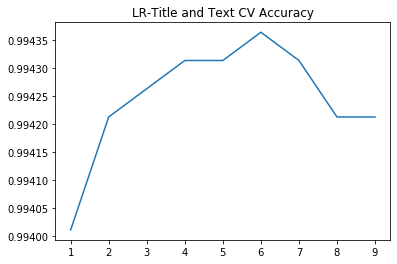

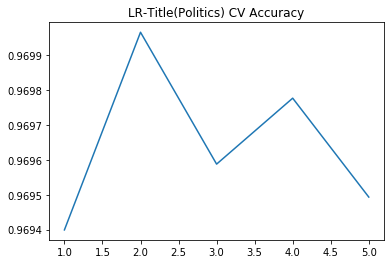

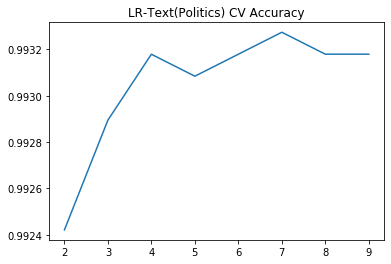

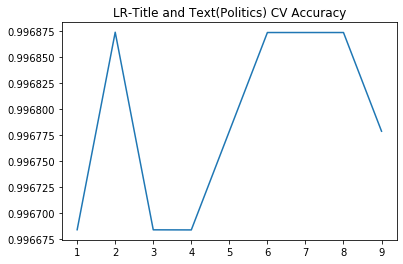

In [1081]:
plt.plot(range(1,6),scoresLR_title)
plt.title("LR-Title CV Accuracy")
plt.show()
plt.plot(range(2,10),scoresLR_text)
plt.title("LR-Text CV Accuracy")
plt.show()
plt.plot(range(1,10), scoresLR_title_text)
plt.title("LR-Title and Text CV Accuracy")
plt.show()
plt.plot(range(1,6), scoresLR_title_p)
plt.title("LR-Title(Politics) CV Accuracy")
plt.show()
plt.plot(range(2,10), scoresLR_text_p)
plt.title("LR-Text(Politics) CV Accuracy")
plt.show()
plt.plot(range(1,10), scoresLR_title_text_p)
plt.title("LR-Title and Text(Politics) CV Accuracy")
plt.show()

In [926]:
lr = LogisticRegression(random_state=0, max_iter = 2000, C=2)
clf_lr_title = modelEval(X_train_title, y_train_title, X_test_title, y_test_title, lr, "results_lr_title")

train accuracy: 0.9715788409021948
test accuracy: 0.9677618069815195
train f-score: 0.9723905282808764
test f-score: 0.9686605895269147


In [927]:
lr = LogisticRegression(random_state=0, max_iter = 2000, C=8)
clf_lr_text = modelEval(X_train_text, y_train_text, X_test_text, y_test_text, lr, "results_lr_text")

train accuracy: 0.9969994268568153
test accuracy: 0.9908281998631074
train f-score: 0.9970931182023058
test f-score: 0.9911105214276238


In [928]:
lr = LogisticRegression(random_state=0, max_iter = 2000, C=6)
clf_lr_title_text = modelEval(X_train_title_text, y_train_title_text, X_test_title_text, y_test_title_text, 
                              lr, "results_lr_title_text")

train accuracy: 0.9999662856950204
test accuracy: 0.9964407939767282
train f-score: 0.9999673512031081
test f-score: 0.9965508092332185


In [1040]:
lr = LogisticRegression(random_state=0, max_iter = 2000, C=2)
clf_lr_title_p = modelEval(X_train_title_p, y_train_title_p, X_test_title_p, y_test_title_p,
                           lr, "results_lr_title_p")

train accuracy: 0.9853889795601151
test accuracy: 0.9757021142316188
train f-score: 0.9822239031770045
test f-score: 0.9704073789392775


In [1038]:
lr = LogisticRegression(random_state=0, max_iter = 2000, C=7)
clf_lr_text_p = modelEval(X_train_text_p, y_train_text_p, X_test_text_p, y_test_text_p, 
                          lr, "results_lr_text_p")

train accuracy: 0.9997668454185125
test accuracy: 0.9933733038813506
train f-score: 0.9997179125528914
test f-score: 0.9919694072657744


In [1039]:
lr = LogisticRegression(random_state=0, max_iter = 2000, C=2)
clf_lr_title_text_p = modelEval(X_train_title_text_p, y_train_title_text_p, X_test_title_text_p, y_test_title_text_p, 
                                lr, "results_lr_title_text_p")

train accuracy: 0.9999222818061708
test accuracy: 0.997633322814768
train f-score: 0.9999060062035905
test f-score: 0.9971269871672093


## III. Linear Support Vector Machine

In [654]:
from sklearn.svm import LinearSVC #l2 penalty

In [938]:
# cross validation
def crossValidationLSVM(X, y, hyperparameters):
    scores = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    for h in hyperparameters:
        model = LinearSVC(max_iter = 100000, C=h)
        scores.append(cross_val_score(estimator=model, X=X_train, y=y_train, cv=10).mean())
        
    return scores

In [936]:
scoresLSVM_title = crossValidationLSVM(X_train_title, y_train_title, [0.1,0.3,0.5,0.7,0.9])
scoresLSVM_text = crossValidationLSVM(X_train_text, y_train_text, range(5,15))
scoresLSVM_title_text = crossValidationLSVM(X_train_title_text, y_train_title_text, range(5,15))

In [939]:
scoresLSVM_title_p = crossValidationLSVM(X_train_title_p, y_train_title_p, [0.1,0.3,0.5,0.7,0.9])
scoresLSVM_text_p = crossValidationLSVM(X_train_text_p, y_train_text_p, range(5,15))
scoresLSVM_title_text_p = crossValidationLSVM(X_train_title_text_p, y_train_title_text_p, range(5,15))

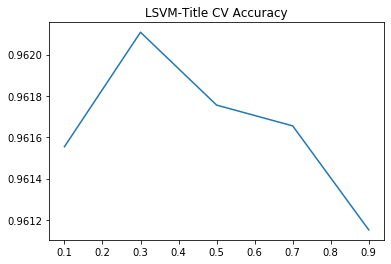

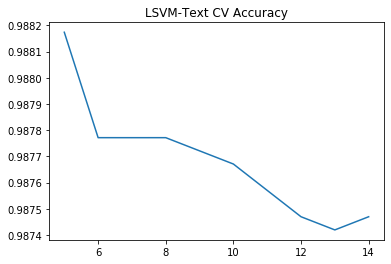

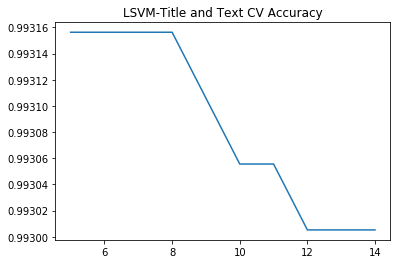

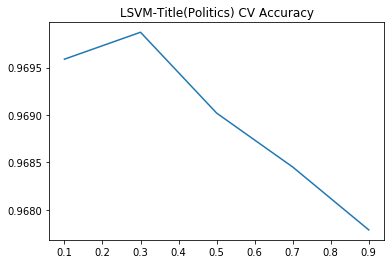

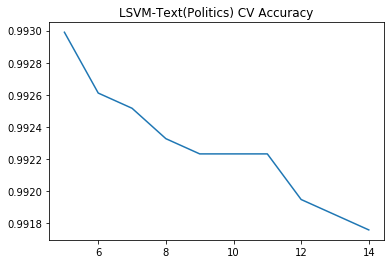

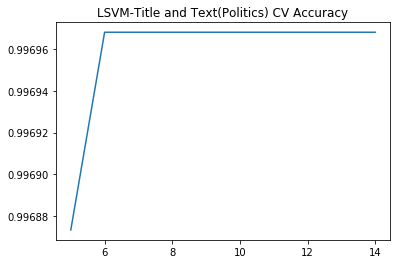

In [945]:
plt.plot([0.1,0.3,0.5,0.7,0.9],scoresLSVM_title)
plt.title("LSVM-Title CV Accuracy")
plt.show()
plt.plot(range(5,15), scoresLSVM_text)
plt.title("LSVM-Text CV Accuracy")
plt.show()
plt.plot(range(5,15), scoresLSVM_title_text)
plt.title("LSVM-Title and Text CV Accuracy")
plt.show()
plt.plot([0.1,0.3,0.5,0.7,0.9], scoresLSVM_title_p)
plt.title("LSVM-Title(Politics) CV Accuracy")
plt.show()
plt.plot(range(5,15), scoresLSVM_text_p)
plt.title("LSVM-Text(Politics) CV Accuracy")
plt.show()
plt.plot(range(5,15), scoresLSVM_title_text_p)
plt.title("LSVM-Title and Text(Politics) CV Accuracy")
plt.show()

In [946]:
lsvc = LinearSVC(max_iter = 10000, C=0.3)
clf_lsvm_title = modelEval(X_train_title, y_train_title, X_test_title, y_test_title, 
                           lsvc, "results_lsvm_title")

train accuracy: 0.9725565557466033
test accuracy: 0.968104038329911
train f-score: 0.9733254686066325
test f-score: 0.9689788310477965


In [951]:
lsvc = LinearSVC(max_iter = 50000, C=5)
clf_lsvm_text = modelEval(X_train_text, y_train_text, X_test_text, y_test_text, 
                          lsvc, "results_lsvm_text")

train accuracy: 0.9990559994605711
test accuracy: 0.9900752908966461
train f-score: 0.9990855649902023
test f-score: 0.9903954428032059


In [952]:
lsvc = LinearSVC(max_iter = 50000, C=5)
clf_lsvm_title_text = modelEval(X_train_title_text, y_train_title_text, X_test_title_text, y_test_title_text, 
                                lsvc, "results_lsvm_title_text")

train accuracy: 1.0
test accuracy: 0.9954140999315537
train f-score: 1.0
test f-score: 0.9955608560259723


In [1067]:
lsvc_p = LinearSVC(max_iter = 10000, C=0.3)
clf_lsvm_title_p = modelEval(X_train_title_p, y_train_title_p, X_test_title_p, y_test_title_p, 
                             lsvc_p, "results_lsvm_title_p")

train accuracy: 0.9871764980181861
test accuracy: 0.9761754496686652
train f-score: 0.9844060107740289
test f-score: 0.9709782817605228


In [1065]:
lsvc_p = LinearSVC(max_iter = 20000, C=5)
clf_lsvm_text_p = modelEval(X_train_text_p, y_train_text_p, X_test_text_p, y_test_text_p, 
                            lsvc_p, "results_lsvm_text_p")

train accuracy: 1.0
test accuracy: 0.9922688545282423
train f-score: 1.0
test f-score: 0.9906291834002677


In [1043]:
lsvc_p = LinearSVC(max_iter = 50000, C=6)
clf_lsvm_title_text_p = modelEval(X_train_title_text_p, y_train_title_text_p, X_test_title_text_p, y_test_title_text_p,
                                  lsvc_p, "results_lsvm_title_text_p")

train accuracy: 1.0
test accuracy: 0.997948879772799
train f-score: 1.0
test f-score: 0.9975119617224881


## IV. Neural Network

In [162]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as optim
from datetime import datetime
import glob, os

In [1049]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, features, labels): #labels will be numpy (n,)
        'Initialization'
        self.features = torch.tensor(features, dtype=torch.float) #instance variables
        self.labels = torch.tensor(labels.reshape(-1,1), dtype=torch.float)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.features[index]
        y = self.labels[index]

        return X, y
    
    def getFeatures(self):
        return self.features

In [1050]:
# create model class
class NeuralNetwork(nn.Module):
    """
    Simplr neural network to intake bert
    """
    
    def __init__(self, p, hid, drop_rate):
        super(NeuralNetwork, self).__init__()
        self.hidden = hid
        self.dropout_rate = drop_rate
        self.l1 = nn.Linear(p, self.hidden, bias=True)  
        self.l2 = nn.Linear(self.hidden, 1, bias=True) 
        
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1, 
            nn.Tanh(), 
            nn.BatchNorm1d(self.hidden),
            nn.Dropout(p=self.dropout_rate), 
            self.l2, 
            nn.Sigmoid()
        )

        return model(x)

In [1051]:
# create function for training (similar to hw8)
def train(X_train_all, y_train_all, X_test, y_test, model, batch_size, num_epochs, criterion, optimizer):
    loss_curve = []
    accuracy_curve = []
    val_accuracy_curve = []
    # create train test split
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42)
    dataloader = DataLoader(Dataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs): # loop over each epoch
        epoch_loss = 0
        total = 0
        correct = 0
        
        for data in dataloader: # loop over each batch
            embeddings, labels = data
            outputs = model(embeddings.float())
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # save train performance
            epoch_loss+=loss.item()
            preds = 1*(outputs>0.5)
            correct += (preds.reshape(-1,1) == labels).sum().item()
            total += float(len(labels))
        
        # train loss and accuracy
        epoch_loss = epoch_loss / len(dataloader)
        epoch_accuracy = correct / total
        loss_curve.append(epoch_loss)
        accuracy_curve.append(epoch_accuracy)
        
        # validation accuracy 
        X_val_t = torch.tensor(X_val, dtype=torch.float) #instance variables
        y_val_t = torch.tensor(y_val.reshape(-1,1), dtype=torch.float)
        val_outputs = model(X_val_t.float())
        val_preds = 1*(val_outputs>0.5)
        val_accuracy = (val_preds.reshape(-1,1) == y_val_t).sum().item()/len(y_val)
        val_accuracy_curve.append(val_accuracy)
        
        # test accuracy 
        X_test_t = torch.tensor(X_test, dtype=torch.float) #instance variables
        y_test_t = torch.tensor(y_test.reshape(-1,1), dtype=torch.float)
        test_outputs = model(X_test_t.float())
        test_preds = 1*(test_outputs>0.5)
        test_accuracy = (test_preds.reshape(-1,1) == y_test_t).sum().item()/len(y_test)
        
        print('epoch [{}/{}], mean epoch loss:{:.4f}, train acc:{:.4f}, val acc:{:.4f}, test acc:{:.4f}'.format(
            epoch + 1, num_epochs, epoch_loss, epoch_accuracy, val_accuracy, test_accuracy))
        
    return model, loss_curve, val_accuracy_curve

In [1052]:
# initiate other inputs
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCELoss()

In [1053]:
# train models - only using title
num_epochs = 7
model_title = NeuralNetwork(X_train_title.shape[1],80,0.3)
optimizer_title = optim.Adam(model_title.parameters(), lr=0.3e-3)
nn_title, loss_curve_title, val_acc_title= train(X_train_title, y_train_title, X_test_title, y_test_title, 
                                 model_title, batch_size, num_epochs, criterion, optimizer_title)

epoch [1/7], mean epoch loss:0.1821, train acc:0.9292, val acc:0.9499, test acc:0.9521
epoch [2/7], mean epoch loss:0.1293, train acc:0.9521, val acc:0.9508, test acc:0.9576
epoch [3/7], mean epoch loss:0.1192, train acc:0.9551, val acc:0.9545, test acc:0.9569
epoch [4/7], mean epoch loss:0.1147, train acc:0.9567, val acc:0.9504, test acc:0.9586
epoch [5/7], mean epoch loss:0.1123, train acc:0.9587, val acc:0.9563, test acc:0.9619
epoch [6/7], mean epoch loss:0.1090, train acc:0.9592, val acc:0.9582, test acc:0.9607
epoch [7/7], mean epoch loss:0.1055, train acc:0.9589, val acc:0.9569, test acc:0.9621


In [1054]:
# train models - only using text
num_epochs = 7
model_text = NeuralNetwork(X_train_text.shape[1],300,0.5)
optimizer_text = optim.Adam(model_text.parameters(), lr=0.5e-3)
nn_text, loss_curve_text, val_acc_text = train(X_train_text, y_train_text, X_test_text, y_test_text, 
                                 model_text, batch_size, num_epochs, criterion, optimizer_text)

epoch [1/7], mean epoch loss:0.0957, train acc:0.9671, val acc:0.9828, test acc:0.9821
epoch [2/7], mean epoch loss:0.0535, train acc:0.9818, val acc:0.9835, test acc:0.9812
epoch [3/7], mean epoch loss:0.0458, train acc:0.9836, val acc:0.9874, test acc:0.9855
epoch [4/7], mean epoch loss:0.0400, train acc:0.9850, val acc:0.9874, test acc:0.9865
epoch [5/7], mean epoch loss:0.0349, train acc:0.9877, val acc:0.9885, test acc:0.9867
epoch [6/7], mean epoch loss:0.0369, train acc:0.9875, val acc:0.9889, test acc:0.9876
epoch [7/7], mean epoch loss:0.0330, train acc:0.9890, val acc:0.9884, test acc:0.9878


In [1055]:
# train models - using text and title
num_epochs = 7
model_title_text = NeuralNetwork(X_train_title_text.shape[1],500,0.7)
optimizer_title_text = optim.Adam(model_title_text.parameters(), lr=0.5e-3)
nn_title_text, loss_curve_title_text, val_acc_title_text = train(X_train_title_text, y_train_title_text, X_test_title_text, y_test_title_text,
                                             model_title_text, batch_size, num_epochs, criterion, optimizer_title_text)

epoch [1/7], mean epoch loss:0.0639, train acc:0.9762, val acc:0.9875, test acc:0.9883
epoch [2/7], mean epoch loss:0.0316, train acc:0.9895, val acc:0.9917, test acc:0.9937
epoch [3/7], mean epoch loss:0.0257, train acc:0.9909, val acc:0.9914, test acc:0.9930
epoch [4/7], mean epoch loss:0.0221, train acc:0.9924, val acc:0.9938, test acc:0.9916
epoch [5/7], mean epoch loss:0.0197, train acc:0.9939, val acc:0.9938, test acc:0.9944
epoch [6/7], mean epoch loss:0.0166, train acc:0.9944, val acc:0.9954, test acc:0.9938
epoch [7/7], mean epoch loss:0.0150, train acc:0.9950, val acc:0.9949, test acc:0.9951


In [1056]:
# train models - only using title_politics
num_epochs = 7
model_title = NeuralNetwork(X_train_title.shape[1],80,0.3)
optimizer_title = optim.Adam(model_title.parameters(), lr=0.3e-3)
nn_title_p, loss_curve_title_p, val_acc_title_p= train(X_train_title_p, y_train_title_p, X_test_title_p, y_test_title_p, 
                                 model_title, batch_size, num_epochs, criterion, optimizer_title)

epoch [1/7], mean epoch loss:0.2075, train acc:0.9218, val acc:0.9542, test acc:0.9576
epoch [2/7], mean epoch loss:0.1206, train acc:0.9603, val acc:0.9600, test acc:0.9643
epoch [3/7], mean epoch loss:0.0997, train acc:0.9656, val acc:0.9643, test acc:0.9711
epoch [4/7], mean epoch loss:0.0888, train acc:0.9696, val acc:0.9670, test acc:0.9699
epoch [5/7], mean epoch loss:0.0828, train acc:0.9713, val acc:0.9701, test acc:0.9722
epoch [6/7], mean epoch loss:0.0785, train acc:0.9728, val acc:0.9697, test acc:0.9737
epoch [7/7], mean epoch loss:0.0745, train acc:0.9745, val acc:0.9697, test acc:0.9733


In [1057]:
# train models - only using text_politics
num_epochs = 7
model_text = NeuralNetwork(X_train_text.shape[1],300,0.5)
optimizer_text = optim.Adam(model_text.parameters(), lr=0.5e-3)
nn_text_p, loss_curve_text_p, val_acc_text_p = train(X_train_text_p, y_train_text_p, X_test_text_p, y_test_text_p, 
                                 model_text, batch_size, num_epochs, criterion, optimizer_text)

epoch [1/7], mean epoch loss:0.1085, train acc:0.9659, val acc:0.9817, test acc:0.9812
epoch [2/7], mean epoch loss:0.0498, train acc:0.9848, val acc:0.9868, test acc:0.9864
epoch [3/7], mean epoch loss:0.0352, train acc:0.9895, val acc:0.9852, test acc:0.9885
epoch [4/7], mean epoch loss:0.0334, train acc:0.9889, val acc:0.9872, test acc:0.9882
epoch [5/7], mean epoch loss:0.0261, train acc:0.9912, val acc:0.9903, test acc:0.9885
epoch [6/7], mean epoch loss:0.0241, train acc:0.9915, val acc:0.9895, test acc:0.9896
epoch [7/7], mean epoch loss:0.0246, train acc:0.9918, val acc:0.9915, test acc:0.9893


In [1058]:
# train models - using text and title_politics
num_epochs = 7
model_title_text = NeuralNetwork(X_train_title_text.shape[1],500,0.7)
optimizer_title_text = optim.Adam(model_title_text.parameters(), lr=0.5e-3)
nn_title_text_p, loss_curve_title_text_p, val_acc_title_text_p = train(X_train_title_text_p, y_train_title_text_p, X_test_title_text_p, y_test_title_text_p,
                                             model_title_text, batch_size, num_epochs, criterion, optimizer_title_text)

epoch [1/7], mean epoch loss:0.0649, train acc:0.9772, val acc:0.9918, test acc:0.9912
epoch [2/7], mean epoch loss:0.0230, train acc:0.9924, val acc:0.9934, test acc:0.9932
epoch [3/7], mean epoch loss:0.0156, train acc:0.9957, val acc:0.9965, test acc:0.9948
epoch [4/7], mean epoch loss:0.0127, train acc:0.9961, val acc:0.9953, test acc:0.9942
epoch [5/7], mean epoch loss:0.0116, train acc:0.9962, val acc:0.9957, test acc:0.9959
epoch [6/7], mean epoch loss:0.0080, train acc:0.9976, val acc:0.9961, test acc:0.9961
epoch [7/7], mean epoch loss:0.0084, train acc:0.9977, val acc:0.9957, test acc:0.9962


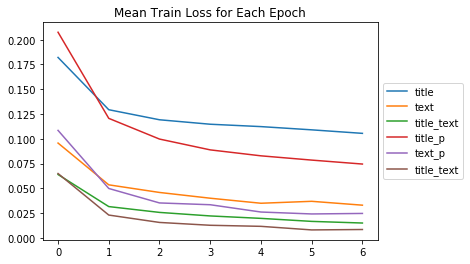

In [1059]:
plt.plot(loss_curve_title, label = "title")
plt.plot(loss_curve_text, label = "text")
plt.plot(loss_curve_title_text, label = "title_text")
plt.plot(loss_curve_title_p, label = "title_p")
plt.plot(loss_curve_text_p, label = "text_p")
plt.plot(loss_curve_title_text_p, label = "title_text")
plt.title("Mean Train Loss for Each Epoch")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

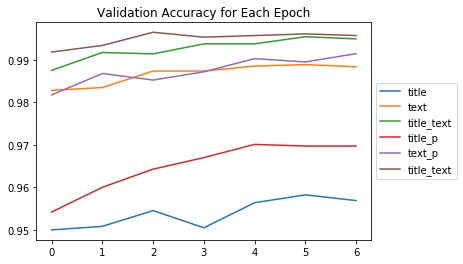

In [1060]:
plt.plot(val_acc_title, label = "title")
plt.plot(val_acc_text, label = "text")
plt.plot(val_acc_title_text, label = "title_text")
plt.plot(val_acc_title_p, label = "title_p")
plt.plot(val_acc_text_p, label = "text_p")
plt.plot(val_acc_title_text_p, label = "title_text")
plt.title("Validation Accuracy for Each Epoch")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## LIME (Future potential work)
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Lime%20-%20basic%20usage%2C%20two%20class%20case.ipynb